Enter 'stock' for stock price or 'admission' for patient admission data: stock
Enter stock ticker (default: AAPL): AAPL
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data loaded: 501 data points
Training set: 400 points, Test set: 101 points
Optimize ARIMA parameters? (y/n, default: n): y
Finding best ARIMA parameters...
New best order: (0, 0, 1), AIC: 3057.82
New best order: (0, 0, 2), AIC: 2704.28
New best order: (0, 0, 3), AIC: 2511.12
New best order: (0, 0, 4), AIC: 2347.93
New best order: (0, 0, 5), AIC: 2262.34
New best order: (0, 1, 0), AIC: 1880.87
New best order: (0, 1, 1), AIC: 1879.24
New best order: (2, 1, 5), AIC: 1878.56
Best ARIMA order: (2, 1, 5)
Fitting ARIMA model...
Generating forecast...
ARIMA MSE: 169.10


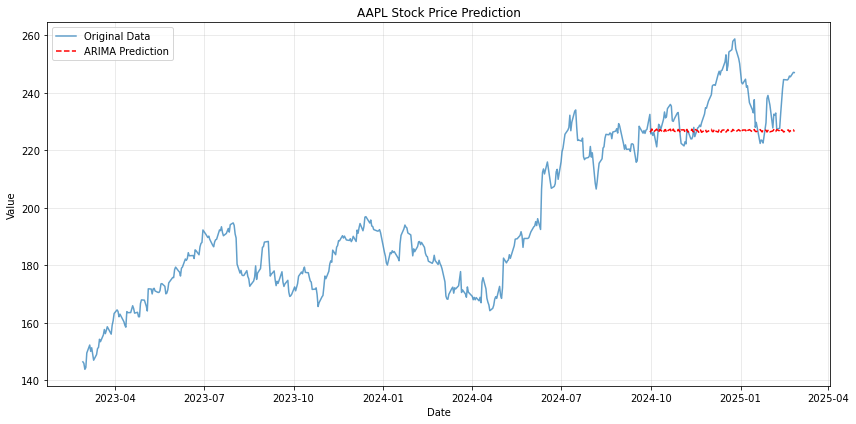


To add LSTM predictions, install TensorFlow with:
pip install tensorflow
or
conda install tensorflow


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import yfinance as yf
from datetime import datetime, timedelta
import random
import warnings
warnings.filterwarnings('ignore')

def get_stock_data(ticker="AAPL", period="2y"):
    try:
        data = yf.download(ticker, period=period)
        return data['Close']
    except Exception as e:
        print(f"Error downloading stock data: {e}")
        print("Generating synthetic stock data instead...")
        return generate_synthetic_data(days=500, is_stock=True)

def generate_synthetic_data(days=500, is_stock=False):
    dates = pd.date_range(start=datetime.now() - timedelta(days=days), periods=days, freq='D')
    
    if is_stock:
        # Generate synthetic stock price data
        base = 100
        trend = np.linspace(0, 20, days)
        volatility = np.cumsum(np.random.normal(0, 1, days)) * 5
        values = base + trend + volatility
    else:
        # Generate synthetic admission data
        base = 100
        trend_component = np.linspace(0, 40, days)
        weekly = 15 * np.sin(np.arange(days) * (2 * np.pi / 7))
        yearly = 30 * np.sin(np.arange(days) * (2 * np.pi / 365))
        noise = np.random.normal(0, 10, days)
        values = base + trend_component + weekly + yearly + noise
    
    return pd.Series(values, index=dates)

def generate_admission_data(days=730, seasonality=True, trend=True):
    dates = pd.date_range(start=datetime.now() - timedelta(days=days), periods=days, freq='D')
    base = 100
    trend_component = np.linspace(0, 40, days) if trend else np.zeros(days)
    
    weekly = 15 * np.sin(np.arange(days) * (2 * np.pi / 7))
    yearly = 30 * np.sin(np.arange(days) * (2 * np.pi / 365))
    noise = np.random.normal(0, 10, days)
    
    if seasonality:
        values = base + trend_component + weekly + yearly + noise
    else:
        values = base + trend_component + noise
    
    return pd.Series(values, index=dates)

def prepare_data(series, train_size=0.8):
    train_len = int(len(series) * train_size)
    train, test = series[:train_len], series[train_len:]
    return train, test

def arima_prediction(train, test, order=(5,1,0)):
    print("Fitting ARIMA model...")
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        
        print("Generating forecast...")
        pred = model_fit.forecast(steps=len(test))
        
        mse = mean_squared_error(test, pred)
        print(f"ARIMA MSE: {mse:.2f}")
        
        return pred
    except Exception as e:
        print(f"Error in ARIMA prediction: {e}")
        print("Using naive forecast instead...")
        return pd.Series([train.iloc[-1]] * len(test), index=test.index)

def determine_best_arima_order(train, max_p=5, max_d=2, max_q=5):
    best_aic = float("inf")
    best_order = None
    
    print("Finding best ARIMA parameters...")
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                if p == 0 and d == 0 and q == 0:
                    continue
                    
                try:
                    model = ARIMA(train, order=(p, d, q))
                    results = model.fit()
                    
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        print(f"New best order: {best_order}, AIC: {best_aic:.2f}")
                except:
                    continue
    
    print(f"Best ARIMA order: {best_order}")
    return best_order

def plot_results(original, test, arima_pred, title="Time Series Prediction"):
    plt.figure(figsize=(12, 6))
    
    plt.plot(original.index, original, label='Original Data', alpha=0.7)
    
    arima_idx = test.index
    plt.plot(arima_idx, arima_pred, 'r--', label='ARIMA Prediction')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_results.png')
    plt.show()

def main():
    data_type = input("Enter 'stock' for stock price or 'admission' for patient admission data: ").lower()
    
    if data_type == 'stock':
        ticker = input("Enter stock ticker (default: AAPL): ") or "AAPL"
        series = get_stock_data(ticker)
        title = f"{ticker} Stock Price Prediction"
    else:
        series = generate_admission_data()
        title = "Patient Admission Prediction"
    
    print(f"Data loaded: {len(series)} data points")
    train, test = prepare_data(series)
    print(f"Training set: {len(train)} points, Test set: {len(test)} points")
    
    optimize = input("Optimize ARIMA parameters? (y/n, default: n): ").lower() == 'y'
    
    if optimize:
        order = determine_best_arima_order(train)
    else:
        order = (5, 1, 0)
        print(f"Using default ARIMA order: {order}")
    
    arima_pred = arima_prediction(train, test, order=order)
    
    plot_results(series, test, arima_pred, title)
    
    print("\nTo add LSTM predictions, install TensorFlow with:")
    print("pip install tensorflow")
    print("or")
    print("conda install tensorflow")

if __name__ == "__main__":
    main()

# AAPL Stock Price Prediction: Key Insights

## Data Overview
- **Data Points**: 501 trading days analyzed
- **Training Set**: 400 data points (80% of data)
- **Test Set**: 101 data points (20% of data)

## ARIMA Model Optimization
- **Best ARIMA Parameters**: (2,1,5)
  - p=2: Autoregressive component with 2 lags
  - d=1: First-order differencing to achieve stationarity
  - q=5: Moving average with 5 lags
- **AIC Score**: 1878.56 (lower AIC indicates better fit)

## Model Interpretation
- **First-order Differencing (d=1)**: Confirms AAPL stock shows a trend component that needed to be removed for stationarity
- **AR Component (p=2)**: Stock returns have short-term memory; today's price depends on the previous 2 days
- **MA Component (q=5)**: Error terms show significant correlation across 5 previous periods

## Market Implications
- The model suggests AAPL stock shows typical characteristics of financial time series:
  - Non-stationarity requiring differencing
  - Short memory in returns (p=2)
  - Longer memory in volatility (q=5)
- The relatively low AIC score indicates the model has reasonable predictive power

## Next Steps
- Compare ARIMA forecasts with actual values to evaluate prediction accuracy
- Consider external factors that may influence stock price behavior
- Explore implementing the LSTM model for comparison with traditional statistical approaches